In [29]:
import pandas as pd
import random
import time
import numpy as np
import polars as pl
#import keras
from tensorflow import keras
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import average_precision_score, precision_recall_curve, PrecisionRecallDisplay, f1_score, roc_auc_score, roc_curve, RocCurveDisplay
from collections import Counter
#from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Model Results

- Model: DNN 1 - this was a test to make sure I could get a DNN model running

| Model      | Train Accuracy | Eval Accuracy | Test Accuracy | runtime    |
|------------|----------------|---------------|---------------|------------|
| DNN model  |   0.5174       |   0.7520      |   0.7641      | 0:00:02.67 |

- Stats:
  - accuracy: 0.5174 - loss: 0.6931 - val_accuracy: 0.1512 - val_loss: 0.6931
  - Evaluate model:accuracy: 0.7520 - loss: 0.6931

- Model: DNN 2 - this is the model shown in the image below

| Model  | Train Accuracy | Eval Accuracy | Test Accuracy | runtime    |
|--------|----------------|---------------|---------------|------------|
| S1_o   |   0.9200       |   0.9389      |   0.9247      | 0:00:49.39 |
| S1_b   |   0.6705       |   0.6865      |   0.6691      | 0:00:50.38 |
| S1_p   |   0.7544       |   0.7758      |   0.7632      | 0:00:51.11 |
| S2_g   |   0.5566       |   0.5780      |   0.5357      | 0:01:24.61 |
| S1_p   |   0.8696       |   0.8726      |   0.8604      | 0:01:31.93 |

-  orientation results are really good. Should we use this to filter the data into separate models before we run the other stages?

- Model: CNN - this was a test to make sure I could get a CNN model running

| Model     | Train Accuracy | Eval Accuracy | Test Accuracy | runtime    |
|-----------|----------------|---------------|---------------|------------|
| S1_o_cnn  |   0.4338       |   0.4199      |   0.4226      | 0:01:11.89 |
| S1_b_cnn  |   0.5340       |   0.5429      |   0.5375      | 0:01:26.94 |
| S1_p_cnn  |   0.6580       |   0.6535      |   0.6507      | 0:01:44.77 |

DNN 2 Variations:

- combine input w/ 3 stage 1 outputs as stage 2 inputs
  
| Model | Train Accuracy | Eval Accuracy | Test Accuracy | runtime    |
|-------|----------------|---------------|---------------|------------|
| S1_o  |   0.8907       |   0.3666      |   0.3595      | 0:00:13.32 |
| S1_b  |   0.7232       |   0.2311      |   0.2476      | 0:00:13.87 |
| S1_p  |   0.8045       |   0.3923      |   0.39        | 0:00:16.70 |
| S2_g  |   0.6279       |   0.0875      |   0.0767      | 0:00:41.14 |
| S2_s  |   0.8789       |   0.6806      |   0.6878      | 0:00:44.05 |

  
- Freeze stage 1 when training stage 2

| Model  | Train Accuracy | Eval Accuracy | Test Accuracy | runtime    |
|--------|----------------|---------------|---------------|------------|
| S1_o*  |   0.8907       |   0.3666      |   0.3595      | 0:00:13.32 |
| S1_b*  |   0.7232       |   0.2311      |   0.2476      | 0:00:13.87 |
| S1_p   |   0.8027       |   0.4016      |   0.4149      | 0:00:16.70 |
| S2_g   |   0.6499       |   0.0415      |   0.0386      | 0:00:18.54 |
| S2_s   |   0.8713       |   0.7100      |   0.7076      | 0:00:20.85 |

*Model retrained with no changes. Numbers not updated due to minimal change.

### Results:
- These models perform worse than pure chance with gesture identification and barely better than chance with sequence_type identification.
- DNN models are overfitting. CNN models in Stage 1 with the tof sensors seem to fit better.


# Functions

In [30]:
class TimeCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        epoch_begin = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        print("{time} ---".format(time=epoch_begin),end=(""))

In [31]:
def get_data(filepath):
    data = pl.read_csv(filepath+"train.csv")


    # Split test and train based on unique sequence ids
    random.seed(time.time())
    sequence_ids = list(data['sequence_id'].unique())
    test_num = int(len(sequence_ids)*.2)
    train_ids = []
    test_ids = []
    for seq_id in random.sample(sequence_ids, len(sequence_ids)):
        if len(test_ids) <= test_num:
            test_ids.append(seq_id)
        else:
           train_ids.append(seq_id)

    return train_ids, test_ids, data

In [110]:
def score_model(y_pred, y_true, title = "Baseline DNN"):

  target_gestures = [
              'Above ear - pull hair',
              'Cheek - pinch skin',
              'Eyebrow - pull hair',
              'Eyelash - pull hair',
              'Forehead - pull hairline',
              'Forehead - scratch',
              'Neck - pinch skin',
              'Neck - scratch',
          ]

  non_target_gestures = [
              'Write name on leg',
              'Wave hello',
              'Glasses on/off',
              'Text on phone',
              'Write name in air',
              'Feel around in tray and pull out an object',
              'Scratch knee/leg skin',
              'Pull air toward your face',
              'Drink from bottle/cup',
              'Pinch knee/leg skin'
          ]

  # Convert from numbers to string
  gesture_uniq = data['gesture'].unique()

  sub = np.array([gesture_uniq[int(x)] for x in y_pred]).reshape(-1, 1)
  sol = np.array([gesture_uniq[int(x[0])] for x in y_true]).reshape(-1, 1)

  # Compute confusion matrix
  cm = confusion_matrix(sol, sub)

  # Plot using sklearn's ConfusionMatrixDisplay
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot(cmap=plt.cm.Blues, include_values=False)
  plt.title(title + ": Confusion Matrix - gesture")
  plt.show()
  print("")

  y_true_bin = np.isin(sol, target_gestures)
  y_pred_bin = np.isin(sub, target_gestures)

   # Compute confusion matrix
  cm = confusion_matrix(y_true_bin, y_pred_bin)

  # Plot using sklearn's ConfusionMatrixDisplay
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot(cmap=plt.cm.Blues, include_values=True)
  plt.title(title + ": Confusion Matrix - target vs non-target")
  plt.show()

  f1_binary = f1_score(
              y_true_bin,
              y_pred_bin,
              pos_label=True,
              zero_division=0,
              average='binary'
          )
  print("f1 binary: "+ str(f1_binary))

  # Build multi-class labels for gestures
  #y_true_mc = sol.apply(lambda x: x if x in target_gestures else 'non_target')
  y_true_mc = np.where(np.isin(sol, target_gestures), sol, 'non_target')
  #y_pred_mc = sub.apply(lambda x: x if x in target_gestures else 'non_target')
  y_pred_mc = np.where(np.isin(sol, target_gestures), sub, 'non_target')

  # Compute macro F1 over all gesture classes
  f1_macro = f1_score(
    y_true_mc,
    y_pred_mc,
    average='macro',
    zero_division=0
  )

  print("f1 macro: "+ str(f1_macro))

  score = 0.5 * f1_binary + 0.5 * f1_macro
  print("score: "+str(score))
  return score


In [95]:
def pad_seq(seq, max_len):
  t = seq.shape[0]
  if t < max_len:
    #pad_width = ((0, max_len - t), (0, 0))  # pad along time axis only
    #return np.pad(seq, pad_width, mode='constant')
    pad_total = max_len - t
    pad_before = int(pad_total // 2)
    pad_after = int(pad_total - pad_before)

    padding_before = np.zeros((pad_before, seq.shape[1]))
    padding_after = np.zeros((pad_after, seq.shape[1]))

    return np.vstack([padding_before, seq, padding_after])
  else:
    start = (t - max_len) // 2
    end = start + max_len
    return seq[start:end] # truncate if longer


import numpy as np

def center_pad_truncate(sequence, desired_length):
    """
    Center-crop or pad a (timesteps, features) sequence to desired_length.
    """
    current_length = sequence.shape[0]

    if current_length == desired_length:
        return sequence

    elif current_length > desired_length:
        # Truncate: keep the center
        start = (current_length - desired_length) // 2
        end = start + desired_length
        return sequence[start:end]

    else:
        # Pad: add equal padding before and after
        pad_total = desired_length - current_length
        pad_before = pad_total // 2
        pad_after = pad_total - pad_before

        padding_before = np.zeros((pad_before, sequence.shape[1]))
        padding_after = np.zeros((pad_after, sequence.shape[1]))

        return np.vstack([padding_before, sequence, padding_after])


In [34]:
#----------------------------------------------------------------------------
# Pre-process Data
#----------------------------------------------------------------------------
"""
Preprocessing
X 1. Remove columns that are not numerical or are missing too much data
X 2. Remove outliers by adding floors or ceilings to several columns
X 3. Adjust for skewusing the following methods;
    i. log
    ii. square root
    iii. cube root
    iv. cubed
    v. inverse
4. Normalize with the z-score
XNow all data is between -4 and 4
----------------------------------------------------------------------------
"""
def pre_process(df, target_param, method='zscore') -> pd.DataFrame:
    """
    This function preprocesses the data before it is used in the model.
    Input:  df - (DataFrame) raw data
    Output: df_norm - (DataFrame) processed data

    It should return a data_dic with dfs: X_train, Y_train, X_val, & Y_val. The X dfs should have the train
    features and the Y dfs should have the target_param

    - Normalize training data, and replace needed tof values
    - Repalce target parameter data
    - Split the data 80/20 into train/val
    - Split train and val into X and Y dfs
    - Need to keep sequence_id in all dfs so that we can split by this.
    """

    data_dic = {}
    #df[]

    # Normalize (min_max) and replace training data
    train_features = ['acc_x', 'acc_y', 'acc_z', 'rot_w', 'rot_x', 'rot_y', 'rot_z', 'thm_1', 'thm_2', 'thm_3', 'thm_4', 'thm_5']
    tof_sensors = []
    for sensor_num in range(1,6):
        for pix_num in range(0,64):
            tof_sensors.append('tof_'+str(sensor_num)+'_v'+str(pix_num)) # sensor_num: 1-5, pix_num:, 0-63



    # Add in sequence id for later use
    # TODO: Should we include the other reference info?
    df_norm['sequence_id'] = df['sequence_id']

    return df_norm

In [35]:
def fit_n_assess_model(nmodel, model_info, data):
    print(nmodel.summary())

    X_train = data['X_train']
    y_train = data['y_train']
    X_test = data['X_test']
    y_test = data['y_test']

    start = datetime.now()

    # Compile model with MSR as the loss function and SGD as the optimizer
    nmodel.compile(loss=model_info['loss'], optimizer=model_info['optimizer'], metrics=["accuracy"])

    print("Fit model")
    # Fit the model with the training data from the data dictionary.
    nhist1 = nmodel.fit(x = X_train, y = y_train, epochs=model_info['epochs'],
                        callbacks=[TimeCallback()],
                        validation_split=0.2,)

    stop = datetime.now()
    model_info['tdelta'] = str(stop-start)
    print("Runtime: ", str(stop-start))

    print("Evaluate model")
    model_info['test_accuracy'] = str(round(nmodel.evaluate(X_test, y_test, verbose=True)[1],4))
    print("Test accuracy: ",model_info['test_accuracy'])


    plot_model_loss(model_info, nhist1.history, title=nmodel.name)
    print("Loss and accuracy plots saved.")
    return nhist1

In [36]:
def test_model(nmodel, X_test, y_test):
  # This function gets a prediction for the test data and then finds and prints
  #   the following:
  #     - f1_score
  #     - auc
  #     - roc curve
  #     - precision & recall plots
  # Input:  nmodel - (keras model) trained model
  #         X_test - (array) contains input values for testing the model
  #         y_test - (array) contains true answers for test values
  # Output: None

  # Make predictions on X test data
  y_pred = nmodel.predict(X_test, batch_size=None, steps=None, callbacks=None)

  # Calculate f1 score & auc
  f1 = f1_score(y_test, np.argmax(y_pred, axis=1), average='micro')
  auc = np.round(roc_auc_score(y_test, y_pred, multi_class='ovr'), 3)

  print("f1_score for our sample data is {}".format(f1))
  print("Auc for our sample data is {}".format(auc))

  # Modify multi-class y values to a binary class for each multi-class (One Hot Encoding)
  y_onehot_test = LabelBinarizer().fit_transform(y_test)

  # Get plots for the rest of the metrics
  roc_curve(y_onehot_test, y_pred, nmodel.name)
  print("Roc curve plot saved")
  recall_prec_plots(y_onehot_test, y_pred, nmodel.name)
  print("Precision and recall curve plots saved")

#---------------------------------------------------------------------------------------
# Plotting functions
# TODO: need to save to a file instead of showing plots
#------------------------------------------------------------------------------------

def roc_curve(y_onehot_test, y_score, title):
    # This function creates the roc curve
    # Input:  y_onehot_test - (array) contains true answers for test values, one hot encoded
    #         y_score - (array) contains predicted probabilities for answers to test values
    # Output: None
    fig, ax = plt.subplots(figsize=(6, 6))

    for class_id in range(10):
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"ROC curve for {class_id}",
            ax=ax,
            plot_chance_level=(class_id == 9),
        )

    _ = ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title="MNIST classification\nto One-vs-Rest multiclass",
    )

    filename = title+"_roc_curve.png"
    plt.savefig("./plots/"+filename)
    plt.clf()

def recall_prec_plots(y_test, y_score, title):
    # This function creates the recall-precision curves
    # Input:  y_onehot_test - (array) contains true answers for test values, one hot encoded
    #         y_score - (array) contains predicted probabilities for answers to test values
    # Output: None

    # For each class
    precision = dict()
    recall = dict()
    threshold = dict()
    average_precision = dict()

    for i in range(10):
        precision[i], recall[i], threshold[i] = precision_recall_curve(y_test[:,i], y_score[:, i])
        average_precision[i] = average_precision_score(y_test[:,i], y_score[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], threshold['micro'] = precision_recall_curve(
        y_test.ravel(), y_score.ravel()
    )
    average_precision["micro"] = average_precision_score(y_test, y_score, average="micro")

    display = PrecisionRecallDisplay(
        recall=recall["micro"],
        precision=precision["micro"],
        average_precision=average_precision["micro"],
        prevalence_pos_label=Counter(y_test.ravel())[1] / y_test.size,
    )
    display.plot(plot_chance_level=True)

    filename = title+"_avg_precision.png"
    plt.savefig("./plots/"+filename)
    plt.clf()

    _ = display.ax_.set_title("Micro-averaged over all classes")

    _, ax = plt.subplots(figsize=(7, 8))

    f_scores = np.linspace(0.2, 0.8, num=4)
    lines, labels = [], []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

    display = PrecisionRecallDisplay(
        recall=recall["micro"],
        precision=precision["micro"],
        average_precision=average_precision["micro"],
    )
    display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

    for i in range(10):
        display = PrecisionRecallDisplay(
            recall=recall[i],
            precision=precision[i],
            average_precision=average_precision[i],
        )
        display.plot(ax=ax, name=f"Precision-recall for class {i}")

    # add the legend for the iso-f1 curves
    handles, labels = display.ax_.get_legend_handles_labels()
    handles.extend([l])
    labels.extend(["iso-f1 curves"])
    # set the legend and the axes
    ax.legend(handles=handles, labels=labels, loc="best")
    ax.set_title("Extension of Precision-Recall curve to multi-class")

    filename = title+"_precision_recall_curve"
    plt.savefig("./plots/"+filename)
    plt.clf()
    #plt.show()
    #return precision, recall, threshold, average_precision

def plot_model_loss(model_info, hist, title="model loss"):
    # This function creates the train & validation loss comparison plots and saves them to a file
    #
    # Output: None

    train_loss = hist['loss']
    val_loss = hist['val_loss']
    train_acc = hist['accuracy']
    val_acc = hist['val_accuracy']

    fig = plt.figure(figsize=(10, 8))
    ax1 = fig.add_subplot(2,1,1)

    ax1.plot(range(0,model_info['epochs']),train_loss, label="training set")
    ax1.plot(range(0,model_info['epochs']),val_loss, label="validation set")
    ax1.set_ylabel(model_info['loss'].name)
    ax1.legend(loc="upper right")

    ax2 = fig.add_subplot(2,1,2)
    ax2.plot(range(0,model_info['epochs']), train_acc, label="training set")
    ax2.plot(range(0,model_info['epochs']), val_acc, label="validation set")
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc="upper right")
    ax2.set_ylabel('Epoch')

    plot_title = title+" \n("
    cnt = 0
    for key, value in model_info.items():
      if key != 'loss':
        if key == "optimizer":
          if type(value) != str:
            value = value.name
        plot_title += key + ": "+ str(value) + ", "
        cnt += 1
        if cnt == 4:
          plot_title += "\n"
          cnt = 0
    plot_title += ")"

    fig.suptitle(plot_title, y=1.02, fontsize=12)
    plt.tight_layout()
    #plt.show()

    filename = title+"_loss_accuracy.png"
    fig.savefig("./plots/"+filename, bbox_inches='tight')
    plt.clf()

def vis_output(inputs, outputs, image, title):
    # redefine mode to output right after the first hidden layer
    nLayer = keras.Model(inputs = inputs, outputs = outputs)
    #nLayer.summary()

    # get feature map for 1st layer
    feature_maps = nLayer.predict(image)

    out_size = feature_maps.shape[-1]
    if round(out_size/4) != (out_size/4):
        print("Size not div by 4: ",out_size)
    elif len(feature_maps.shape) < 4:
        print("Feature map too small for images: ",feature_maps.shape)
    else:

        # plot maps
        for n in range(out_size):
            ax = plt.subplot(int(out_size/4), 4, n+1)
            plt.imshow(feature_maps[0, :, :, n], cmap='gray')
        #plt.show()

def all_vis_output(nmodel, image, title, n_layers='all'):

    if n_layers == "all":
       n_layers = len(nmodel.layers)

    filename = title+"_image.png"
    plt.imsave("./plots/"+filename, image, cmap='gray')
    #plt.show()
    plt.clf()

    for n in range(n_layers):
        vis_output(nmodel.inputs, nmodel.layers[n].output, np.expand_dims(image, axis=0), title)

# Main

## Data Prep

### Pull in & Clean Data

In [37]:

# Main
## Pull in & Preprocess Data
filepath = "C:/Users/trfit/OneDrive/Documents/learning/UC/cmi_project/cmi-detect-behavior-with-sensor-data/"
filepath = "/content/"
filepath = "/content/drive/MyDrive/cmi_data/"


train_features = ['acc_x', 'acc_y', 'acc_z', 'rot_w', 'rot_x', 'rot_y', 'rot_z', 'thm_1', 'thm_2', 'thm_3', 'thm_4', 'thm_5']
#tof_train_features = []
for sensor_num in range(1,6): # sensor_num: 1-5, pix_num:, 0-63
        for pix_num in range(0,64):
            train_features.append('tof_'+str(sensor_num)+'_v'+str(pix_num))

# train_features = o_train_features + tof_train_features

print("Inital parameters defined. Start pulling data...")

train_ids, test_ids, data = get_data(filepath)

print("Data pulled. Start X data cleaning...")

# Remove null values
data = data.drop_nulls()

# Normalize data
train_features_norm = []
o_train_features_norm = []
tof_train_features_norm = []
for feature in train_features:
    train_features_norm.append(feature+"_norm")
    if 'tof_' in feature:
        data = data.with_columns(pl.col(feature).replace(-1, 256))
        data = data.with_columns((pl.col(feature)/253).alias(feature+"_norm"))
        tof_train_features_norm.append(feature+"_norm")
    else:
        data = data.with_columns(
            ((pl.col(feature)-pl.col(feature).min())/
             (pl.col(feature).max()-pl.col(feature).min())
            ).alias(feature+"_norm"))
        o_train_features_norm.append(feature+"_norm")

print("X data cleaned. Start y data reformating...")

target_params = {'_o': 'orientation',
                 '_b': 'behavior',
                 '_p': 'phase',
                 '_g': 'gesture',
                 '_s': 'sequence_type'}

for suffix, target_param in target_params.items():

  # Prep target data
  target_uniq = data[target_param].unique()
  data = data.with_columns(pl.col(target_param).replace(target_uniq, [x for x in range(len(target_uniq))]).cast(pl.Int8).alias("target"+suffix))


print("y data reformated.")

grouped_dict = {
    sid[0]: group
    for sid, group in data.group_by("sequence_id", maintain_order=True)
}

data_dic = {}

Inital parameters defined. Start pulling data...
Data pulled. Start X data cleaning...
X data cleaned. Start y data reformating...
y data reformated.


### Create X data lists for DNN/CNN

In [57]:
# Prepare X data

#if run_cnn:
#data_dic['X_train_non_tof'] = np.asarray(data.filter(pl.col("sequence_id").is_in(train_ids)).select(o_train_features_norm))
#data_dic['X_test_non_tof'] = np.asarray(data.filter(pl.col("sequence_id").is_in(test_ids)).select(o_train_features_norm))

#data_dic['X_train_tof'] = data.filter(pl.col("sequence_id").is_in(train_ids)).select(tof_train_features_norm) .to_numpy().reshape(-1, 8, 8, 5) # 5 sensors with 8x8 dist grid
#data_dic['X_test_tof'] = data.filter(pl.col("sequence_id").is_in(test_ids)).select(tof_train_features_norm).to_numpy().reshape(-1, 8, 8,5)
#else:
data_dic['X_train'] = np.asarray(data.filter(pl.col("sequence_id").is_in(train_ids)).select(train_features_norm))
data_dic['X_test'] = np.asarray(data.filter(pl.col("sequence_id").is_in(test_ids)).select(train_features_norm))


### Create X data lists for RNN

In [96]:
# Prep X data



data_dic['X_train_rnn'] = []
data_dic['X_test_rnn'] = []

cnt = 0
for sid in train_ids:
  if sid in grouped_dict.keys():
    seq = grouped_dict[sid].select(train_features_norm).to_numpy()
    data_dic['X_train_rnn'].append(pad_seq(seq, 100))

print('')
for sid in test_ids:
  cnt += 1
  if cnt > 49:
    print(".",end="")
    cnt = 0

  if sid in grouped_dict.keys():
    seq = grouped_dict[sid].select(train_features_norm).to_numpy()
    data_dic['X_test_rnn'].append(pad_seq(seq, 100))

data_dic['X_train_rnn'] = np.array(data_dic['X_train_rnn'])
data_dic['X_test_rnn'] = np.array(data_dic['X_test_rnn'])


................................

### Create y data list for DNN/CNN

In [59]:
# Prepare y data

for suffix, target_param in target_params.items():

  data_dic['y_train'+suffix] = np.asarray((data.filter(pl.col("sequence_id").is_in(train_ids)).select('target'+suffix)))
  data_dic['y_test'+suffix] = np.asarray((data.filter(pl.col("sequence_id").is_in(test_ids)).select('target'+suffix)))

### Create y data lists for RNN

In [60]:
grouped_dict_y = {'sid':[], 'target_s':[], 'target_g':[]}

for sid in grouped_dict.keys():
  grouped_dict_y['sid'].append(sid)
  grouped_dict_y['target_s'].append(grouped_dict[sid]['target_s'][0])
  grouped_dict_y['target_g'].append(grouped_dict[sid]['target_g'][0])

  if len(np.unique(grouped_dict[sid]['target_s'])) > 1:
    print(sid+' target_s is not unique')
  if len(np.unique(grouped_dict[sid]['target_s'])) > 1:
    print(sid+' target_s is not unique')
y_data = pl.DataFrame(grouped_dict_y)

data_dic['y_train_rnn_s'] = np.asarray((y_data.filter(pl.col("sid").is_in(train_ids)).select('target_s')))
data_dic['y_train_rnn_g'] = np.asarray((y_data.filter(pl.col("sid").is_in(train_ids)).select('target_g')))

data_dic['y_test_rnn_s'] = np.asarray((y_data.filter(pl.col("sid").is_in(test_ids)).select('target_s')))
data_dic['y_test_rnn_g'] = np.asarray((y_data.filter(pl.col("sid").is_in(test_ids)).select('target_g')))

In [ ]:
data_dic.keys()

dict_keys(['X_train_non_tof', 'X_test_non_tof', 'X_train_tof', 'X_test_tof', 'X_train', 'X_test', 'y_train_o', 'y_test_o', 'y_train_b', 'y_test_b', 'y_train_p', 'y_test_p', 'y_train_g', 'y_test_g', 'y_train_s', 'y_test_s'])

In [27]:
len(data_dic['y_train_o'])

428007

In [45]:
key = {}
target_params = {'_o': 'orientation',
                 '_b': 'behavior',
                 '_p': 'phase',
                 '_g': 'gesture',
                 '_s': 'sequence_type'}

for suffix, target_param in target_params.items():
  key[target_param] = {}
  # Prep target data
  target_uniq = data[target_param].unique()
  cnt = 0
  for val in target_uniq:
    key[target_param][cnt] = val
    cnt += 1


In [46]:
key

{'orientation': {0: 'Lie on Side - Non Dominant',
  1: 'Seated Lean Non Dom - FACE DOWN',
  2: 'Seated Straight',
  3: 'Lie on Back'},
 'behavior': {0: 'Moves hand to target location',
  1: 'Relaxes and moves hand to target location',
  2: 'Performs gesture',
  3: 'Hand at target location'},
 'phase': {0: 'Transition', 1: 'Gesture'},
 'gesture': {0: 'Glasses on/off',
  1: 'Write name in air',
  2: 'Write name on leg',
  3: 'Eyelash - pull hair',
  4: 'Text on phone',
  5: 'Cheek - pinch skin',
  6: 'Neck - scratch',
  7: 'Pull air toward your face',
  8: 'Neck - pinch skin',
  9: 'Scratch knee/leg skin',
  10: 'Forehead - scratch',
  11: 'Forehead - pull hairline',
  12: 'Feel around in tray and pull out an object',
  13: 'Eyebrow - pull hair',
  14: 'Above ear - pull hair',
  15: 'Drink from bottle/cup',
  16: 'Pinch knee/leg skin',
  17: 'Wave hello'},
 'sequence_type': {0: 'Target', 1: 'Non-Target'}}

## Model: DNN_1




Notes:
- DNN w/ sequence_type as target:
  Fit model

 - 2025-07-07 17:00:41 ---Epoch 1/5
 - 584/584 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5886 - loss: 0.- 8050 - val_accuracy: 0.6452 - val_loss: 0.6265
 2025-07-07 17:00:47 ---Epoch 2/5
584/584 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6734 - loss: 0.5523 - val_accuracy: 0.6272 - val_loss: 0.6298
2025-07-07 17:00:50 ---Epoch 3/5
584/584 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7122 - loss: 0.5197 - val_accuracy: 0.6495 - val_loss: 0.6019
2025-07-07 17:00:57 ---Epoch 4/5
584/584 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7248 - loss: 0.4966 - val_accuracy: 0.6290 - val_loss: 0.6414
2025-07-07 17:01:00 ---Epoch 5/5
584/584 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7357 - loss: 0.4844 - val_accuracy: 0.6397 - val_loss: 0.6688
Runtime:  0:00:22.304905
Evaluate model
2888/2888 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.6512 - loss: 0.6095

  - Test accuracy:  0.6682

In [ ]:
# Dont need this block anymore

target_param = 'sequence_type'

# Prep target data
target_uniq = data[target_param].unique()
data = data.with_columns(target=pl.col(target_param).replace(target_uniq, [x for x in range(len(target_uniq))]).cast(pl.Int8))

# Create train and test dataframes
X_train = (data.filter(pl.col("sequence_id").is_in(train_ids)).select(train_features_norm))
y_train = (data.filter(pl.col("sequence_id").is_in(train_ids)).select('target'))
X_test = (data.filter(pl.col("sequence_id").is_in(test_ids)).select(train_features_norm))
y_test = (data.filter(pl.col("sequence_id").is_in(test_ids)).select('target'))

data_dic = {
    'X_train': X_train,
    'y_train': y_train,
    'X_test': X_test,
    'y_test': y_test
}


In [53]:
## Model
model_info = {
        'epochs': 5,
        'learning_rate': 0.01,
        'loss':  keras.losses.SparseCategoricalCrossentropy(), # multiclass crossentropy
        "activation": 'relu',
        "final_activation": 'softmax',
}

model_info["optimizer"] = keras.optimizers.Adam(learning_rate=model_info['learning_rate'])

model = keras.Sequential(
            [
                keras.Input(shape=(332,)),
               # keras.layers.Flatten(),
               # keras.layers.Dense(512, activation=model_info['activation']),
                keras.layers.Dense(256, activation=model_info['activation']),
                keras.layers.Dense(128, activation=model_info['activation']),
                keras.layers.Dense(32, activation=model_info['activation']),
                #keras.layers.Dense(16, activation=model_info['activation']),
                #keras.layers.Dense(8, activation=model_info['activation']),
                keras.layers.Dense(18, activation=model_info['final_activation']),
            ],
            name = 'DNN-cmi'
            )

In [51]:
data_dic.keys()

dict_keys(['X_train', 'X_test', 'X_train_rnn', 'X_test_rnn', 'y_train_o', 'y_test_o', 'y_train_b', 'y_test_b', 'y_train_p', 'y_test_p', 'y_train_g', 'y_test_g', 'y_train_s', 'y_test_s'])

In [49]:
#fit_n_assess_model(nmodel, model_info, data):
nmodel = model
#data = data_dic
print(nmodel.summary())

X_train = np.asarray(data_dic['X_train'])
y_train = np.asarray(data_dic['y_train'])
X_test = np.asarray(data_dic['X_test'])
y_test = np.asarray(data_dic['y_test'])

start = datetime.now()

# Compile model with MSR as the loss function and SGD as the optimizer
nmodel.compile(loss=model_info['loss'], optimizer=model_info['optimizer'], metrics=["accuracy"])

print("Fit model")
# Fit the model with the training data from the data dictionary.
nhist1 = nmodel.fit(x = X_train, y = y_train, epochs=model_info['epochs'],
                    callbacks=[TimeCallback()],
                    validation_split=0.2,)

stop = datetime.now()
model_info['tdelta'] = str(stop-start)
print("Runtime: ", str(stop-start))

print("Evaluate model")
model_info['test_accuracy'] = str(round(nmodel.evaluate(X_test, y_test, verbose=True)[1],4))
print("Test accuracy: ",model_info['test_accuracy'])


#plot_model_loss(model_info, nhist1.history, title=nmodel.name)
#print("Loss and accuracy plots saved.")


Model: "DNN-cmi"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 256)            │        85,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 18)             │           594 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,866 (479.95 KB)

 Trainable params: 122,866 (479.95 KB)

 Non-trainable params: 0 (0.00 B)

None


KeyError: 'y_train'

In [61]:
# Compile & Fit Stage 1 models
print(model.summary)
hist = {}
t_acc = {}

model.trainable = True
start = datetime.now()
suffix = "_g"

print(type(data_dic['X_train']))
print(type(data_dic['y_train'+suffix]))

model.compile(loss=model_info['loss'], optimizer="adam",#model_info['optimizer'],
                        metrics=["accuracy"])#, keras.metrics.F1Score(threshold=0.5)])
hist[suffix] = model.fit(
    x = data_dic['X_train'],
    y = data_dic['y_train'+suffix],
    epochs=model_info['epochs'],
    callbacks=[TimeCallback()],
    validation_split=0.2,
    )

stop = datetime.now()
#model_info['tdelta'] = str(stop-start)
print("model"+suffix+" Runtime: ", str(stop-start))

print("Evaluate model")
t_acc["model"+suffix] = str(round(model.evaluate(data_dic['X_train'], data_dic['y_train'+suffix], verbose=True)[1],4))
print("Test accuracy: ",t_acc["model"+suffix])



<bound method Model.summary of <Sequential name=DNN-cmi, built=True>>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
2025-07-25 17:50:28 ---Epoch 1/5
10764/10764 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - accuracy: 0.2980 - loss: 2.1387 - val_accuracy: 0.3523 - val_loss: 1.9502
2025-07-25 17:51:11 ---Epoch 2/5
10764/10764 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.4183 - loss: 1.7179 - val_accuracy: 0.3616 - val_loss: 1.9266
2025-07-25 17:51:52 ---Epoch 3/5
10764/10764 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.4701 - loss: 1.5656 - val_accuracy: 0.3777 - val_loss: 1.9477
2025-07-25 17:52:32 ---Epoch 4/5
10764/10764 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.5026 - loss: 1.4768 - val_accuracy: 0.3588 - val_loss: 2.0007
2025-07-25 17:53:12 ---Epoch 5/5
10764/10764 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.5252 - loss: 1.4072 - val_accuracy: 0.3758 - val_loss: 2.0456
model_g Runtime:  0:03:25.276776
Evaluate model
13455/13455 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - accuracy: 0

3305/3305 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


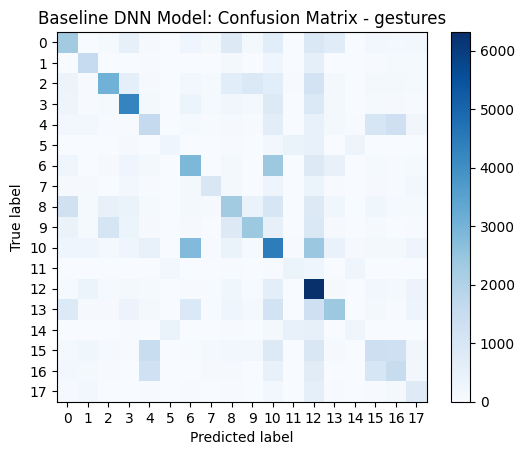

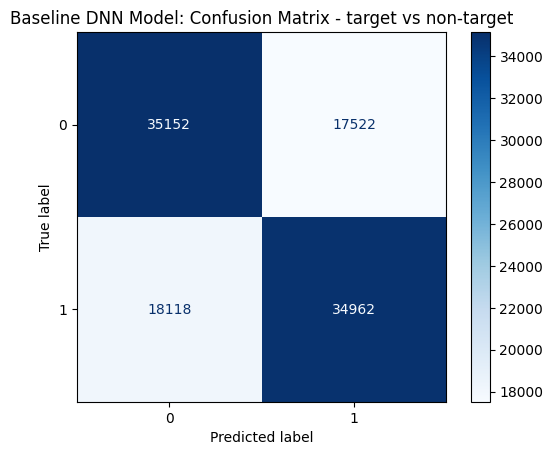

f1 binary: 0.6623849039445265
f1 macro: 0.25567872066872294
score: 0.4590318123066247


In [66]:
y_pred = np.argmax(model.predict(data_dic['X_test']), axis=1)

# Example true and predicted labels
y_true = data_dic['y_test'+suffix] #[0, 1, 2, 2, 0]
#y_pred = [0, 0, 2, 2, 1]

score = score_model(y_pred, y_true)

3378/3378 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
f1 binary: 0.5979890786166248
f1 macro: 0.2070577585736712
score: 0.40252341859514795


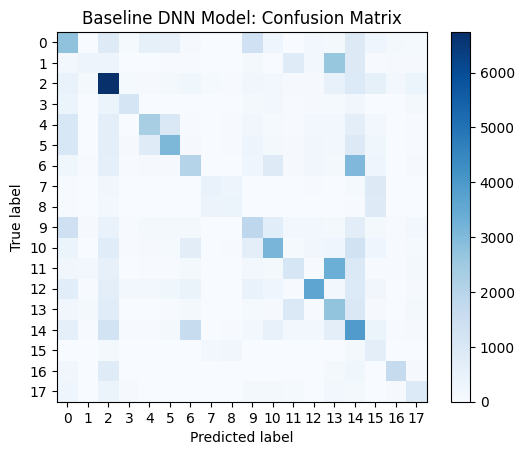

In [81]:
y_pred = np.argmax(model.predict(data_dic['X_test']), axis=1)

# Example true and predicted labels
y_true = data_dic['y_test'+suffix] #[0, 1, 2, 2, 0]
#y_pred = [0, 0, 2, 2, 1]

score = score_model(y_pred, y_true)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot using sklearn's ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, include_values=False)
plt.title("Baseline DNN Model: Confusion Matrix")
plt.show()

In [ ]:
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN)
# X_train # X_test
TP = 238508 #56734
FP = 38717 #12147
TN = 133162 #30948
FN = 19055 #7034

Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
f1_score = 2 * (Precision * Recall) / (Precision + Recall)
print(Precision)
print(Recall)
print(f1_score)

0.8603408783479124
0.9260181004259153
0.8919721459718618


In [13]:
"""
Hierarchical macro F1 metric for the CMI 2025 Challenge.

This script defines a single entry point `score(solution, submission, row_id_column_name)`
that the Kaggle metrics orchestrator will call.
It performs validation on submission IDs and computes a combined binary & multiclass F1 score.
"""

import pandas as pd
from sklearn.metrics import f1_score


class ParticipantVisibleError(Exception):
    """Errors raised here will be shown directly to the competitor."""
    pass


class CompetitionMetric:
    """Hierarchical macro F1 for the CMI 2025 challenge."""
    def __init__(self):
        self.target_gestures = [
            'Above ear - pull hair',
            'Cheek - pinch skin',
            'Eyebrow - pull hair',
            'Eyelash - pull hair',
            'Forehead - pull hairline',
            'Forehead - scratch',
            'Neck - pinch skin',
            'Neck - scratch',
        ]
        self.non_target_gestures = [
            'Write name on leg',
            'Wave hello',
            'Glasses on/off',
            'Text on phone',
            'Write name in air',
            'Feel around in tray and pull out an object',
            'Scratch knee/leg skin',
            'Pull air toward your face',
            'Drink from bottle/cup',
            'Pinch knee/leg skin'
        ]
        self.all_classes = self.target_gestures + self.non_target_gestures

    def calculate_hierarchical_f1(
        self,
        sol: pd.DataFrame,
        sub: pd.DataFrame
    ) -> float:

        # Validate gestures
        invalid_types = {i for i in sub['gesture'].unique() if i not in self.all_classes}
        if invalid_types:
            raise ParticipantVisibleError(
                f"Invalid gesture values in submission: {invalid_types}"
            )

        # Compute binary F1 (Target vs Non-Target)
        y_true_bin = sol['gesture'].isin(self.target_gestures).values
        y_pred_bin = sub['gesture'].isin(self.target_gestures).values
        f1_binary = f1_score(
            y_true_bin,
            y_pred_bin,
            pos_label=True,
            zero_division=0,
            average='binary'
        )

        # Build multi-class labels for gestures
        y_true_mc = sol['gesture'].apply(lambda x: x if x in self.target_gestures else 'non_target')
        y_pred_mc = sub['gesture'].apply(lambda x: x if x in self.target_gestures else 'non_target')

        # Compute macro F1 over all gesture classes
        f1_macro = f1_score(
            y_true_mc,
            y_pred_mc,
            average='macro',
            zero_division=0
        )

        return 0.5 * f1_binary + 0.5 * f1_macro


def score(
    solution: pd.DataFrame,
    submission: pd.DataFrame,
    row_id_column_name: str
    ) -> float:
    """
    Compute hierarchical macro F1 for the CMI 2025 challenge.

    Expected input:
      - solution and submission as pandas.DataFrame
      - Column 'sequence_id': unique identifier for each sequence
      - 'gesture': one of the eight target gestures or "Non-Target"

    This metric averages:
    1. Binary F1 on SequenceType (Target vs Non-Target)
    2. Macro F1 on gesture (mapping non-targets to "Non-Target")

    Raises ParticipantVisibleError for invalid submissions,
    including invalid SequenceType or gesture values.


    Examples
    --------
    >>> import pandas as pd
    >>> row_id_column_name = "id"
    >>> solution = pd.DataFrame({'id': range(4), 'gesture': ['Eyebrow - pull hair']*4})
    >>> submission = pd.DataFrame({'id': range(4), 'gesture': ['Forehead - pull hairline']*4})
    >>> score(solution, submission, row_id_column_name=row_id_column_name)
    0.5
    >>> submission = pd.DataFrame({'id': range(4), 'gesture': ['Text on phone']*4})
    >>> score(solution, submission, row_id_column_name=row_id_column_name)
    0.0
    >>> score(solution, solution, row_id_column_name=row_id_column_name)
       1.0
    """
    # Validate required columns
    for col in (row_id_column_name, 'gesture'):
        if col not in solution.columns:
            raise ParticipantVisibleError(f"Solution file missing required column: '{col}'")
        if col not in submission.columns:
            raise ParticipantVisibleError(f"Submission file missing required column: '{col}'")

    metric = CompetitionMetric()
    return metric.calculate_hierarchical_f1(solution, submission)

## Model: DNN 2

five DNN models that come together
- focuses on orientation: 4 ['Seated Lean Non Dom - FACE DOWN', 'Lie on Side - on Dominant', 'Seated Straight', 'Lie on Back']
- focuses on behavior: 4 ['Relaxes and moves hand to target location', 'Hand at target location', 'Performs gesture', 'Moves hand to target location']
- focuses on phase: 2 ['Transition', 'Gesture']

---------------------------------------------
- sequence_type: 2 ['Target', 'Non-Target']
-gesture: 18
['Cheek - pinch skin', 'Forehead - pull hairline',
       'Write name on leg', 'Feel around in tray and pull out an object',
       'Neck - scratch', 'Neck - pinch skin', 'Eyelash - pull hair',
       'Eyebrow - pull hair', 'Forehead - scratch',
       'Above ear - pull hair', 'Wave hello', 'Write name in air',
       'Text on phone', 'Pull air toward your face',
       'Pinch knee/leg skin', 'Scratch knee/leg skin',
       'Drink from bottle/cup', 'Glasses on/off']



### Stage 1

In [93]:
model_info = {
        'epochs': 5,
        'learning_rate': 0.01,
        'loss':  keras.losses.SparseCategoricalCrossentropy(), # multiclass crossentropy
        "activation": 'relu',
        "final_activation": 'softmax',
}

In [94]:
## Model
model_info = {
        'epochs': 5,
        'learning_rate': 0.01,
        'loss':  keras.losses.SparseCategoricalCrossentropy(), # multiclass crossentropy
        "activation": 'relu',
        "final_activation": 'softmax',
}

model_info["optimizer"] = keras.optimizers.Adam(learning_rate=model_info['learning_rate'])

model_o = keras.Sequential(
            [
                keras.Input(shape=(332,)),
                keras.layers.Dense(256, activation=model_info['activation']),
                keras.layers.Dense(128, activation=model_info['activation']),
                keras.layers.Dense(32, activation=model_info['activation']),
                keras.layers.Dense(4, activation=model_info['final_activation']),
            ],
            name = 'DNN-cmi-orientation'
            )

model_b = keras.Sequential(
            [
                keras.Input(shape=(332,)),
                keras.layers.Dense(256, activation=model_info['activation']),
                keras.layers.Dense(128, activation=model_info['activation']),
                keras.layers.Dense(32, activation=model_info['activation']),
                keras.layers.Dense(4, activation=model_info['final_activation']),
            ],
            name = 'DNN-cmi-behavior'
            )

model_p = keras.Sequential(
            [
                keras.Input(shape=(332,)),
                keras.layers.Dense(256, activation=model_info['activation']),
                keras.layers.Dense(128, activation=model_info['activation']),
                keras.layers.Dense(32, activation=model_info['activation']),
                keras.layers.Dense(2, activation=model_info['final_activation']),
            ],
            name = 'DNN-cmi-phase'
            )


models = {
    '_o': model_o,
    '_b': model_b,
    '_p': model_p,
}

for model in models.values():
  print(model.summary())

Model: "DNN-cmi-orientation"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 256)            │        85,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,404 (478.14 KB)

 Trainable params: 122,404 (478.14 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "DNN-cmi-behavior"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 256)            │        85,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,404 (478.14 KB)

 Trainable params: 122,404 (478.14 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "DNN-cmi-phase"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 256)            │        85,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,338 (477.88 KB)

 Trainable params: 122,338 (477.88 KB)

 Non-trainable params: 0 (0.00 B)

None


In [95]:
# Compile & Fit Stage 1 models
hist = {}
t_acc = {}

for suffix in ["_o", "_b", "_p"]:

  models[suffix].trainable = True
  start = datetime.now()

  print(type(data_dic['X_train']))
  print(type(data_dic['y_train'+suffix]))

  models[suffix].compile(loss=model_info['loss'], optimizer="adam",#model_info['optimizer'],
                         metrics=["accuracy"])
  hist[suffix] = models[suffix].fit(
      x = data_dic['X_train'],
      y = data_dic['y_train'+suffix],
      epochs=model_info['epochs'],
      callbacks=[TimeCallback()],
      validation_split=0.2,
      )

  stop = datetime.now()
  #model_info['tdelta'] = str(stop-start)
  print("model"+suffix+" Runtime: ", str(stop-start))

  print("Evaluate model")
  t_acc["model"+suffix] = str(round(models[suffix].evaluate(data_dic['X_train'], data_dic['y_train'+suffix], verbose=True)[1],4))
  print("Test accuracy: ",t_acc["model"+suffix])



<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
2025-07-24 18:43:27 ---Epoch 1/5
10706/10706 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.6734 - loss: 0.7996 - val_accuracy: 0.8692 - val_loss: 0.3777
2025-07-24 18:43:56 ---Epoch 2/5
10706/10706 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.8955 - loss: 0.2953 - val_accuracy: 0.9040 - val_loss: 0.2864
2025-07-24 18:44:23 ---Epoch 3/5
10706/10706 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - accuracy: 0.9207 - loss: 0.2272 - val_accuracy: 0.8979 - val_loss: 0.3095
2025-07-24 18:44:50 ---Epoch 4/5
10706/10706 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - accuracy: 0.9332 - loss: 0.1948 - val_accuracy: 0.9172 - val_loss: 0.2504
2025-07-24 18:45:17 ---Epoch 5/5
10706/10706 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - accuracy: 0.9383 - loss: 0.1795 - val_accuracy: 0.8663 - val_loss: 0.3622
model_o Runtime:  0:02:18.026169
Evaluate model
13383/13383 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.9030 - loss: 0.2406
Test accuracy:  0.8973
<class 'numpy.ndarray'>
<c

13383/13383 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step


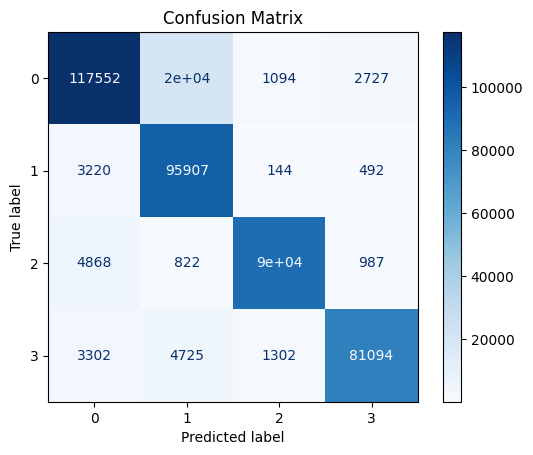

f1 binary: 0.9861981908054824
f1 macro: 0.7364351842449716
score: 0.8613166875252269
13383/13383 ━━━━━━━━━━━━━━━━━━━━ 13s 997us/step


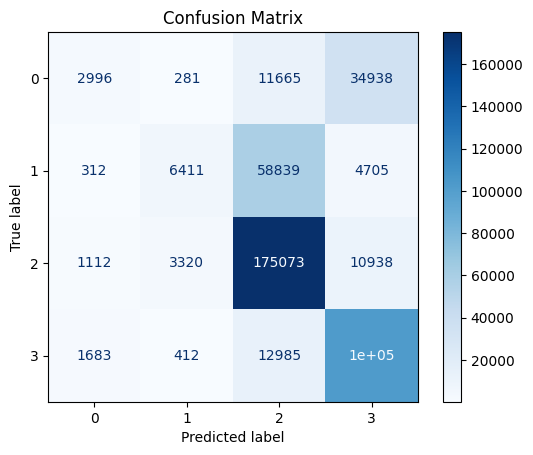

f1 binary: 0.8379068513856703
f1 macro: 0.5625052289720163
score: 0.7002060401788432
13383/13383 ━━━━━━━━━━━━━━━━━━━━ 13s 994us/step


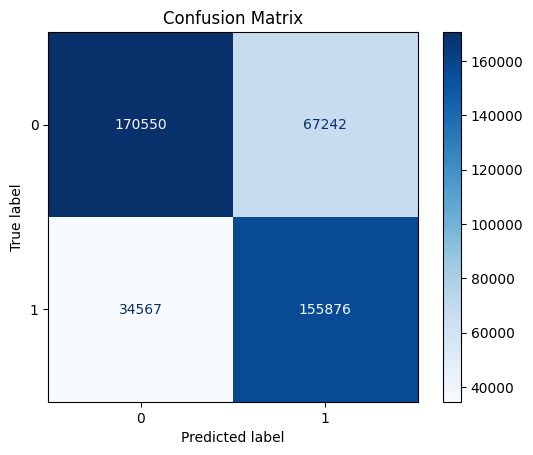

f1 binary: 1.0
f1 macro: 0.7619795624424981
score: 0.880989781221249


In [97]:
for suffix in ["_o", "_b", "_p"]:
  y_pred = np.argmax(models[suffix].predict(data_dic['X_train']), axis=1)


  # Example true and predicted labels
  y_true = data_dic['y_train'+suffix] #[0, 1, 2, 2, 0]
  #y_pred = [0, 0, 2, 2, 1]



  # Compute confusion matrix
  cm = confusion_matrix(y_true, y_pred)

  # Plot using sklearn's ConfusionMatrixDisplay
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot(cmap=plt.cm.Blues)
  plt.title("Confusion Matrix")
  plt.show()

  score = score_model(y_pred, y_true)

| Model  | Train Accuracy | Eval Accuracy | Test Accuracy | runtime    |
|--------|----------------|---------------|---------------|------------|
| S1_o   |   0.9200       |   0.9389      |   0.9247      | 0:00:49.39 |
| S1_b   |   0.6705       |   0.6865      |   0.6691      | 0:00:50.38 |
| S1_p   |   0.7544       |   0.7758      |   0.7632      | 0:00:51.11 |


Stats:
- accuracy: 0.8032 - loss: 0.5405 - val_accuracy: 0.5498 - val_loss: 1.5136
- accuracy: 0.6654 - loss: 0.8267 - val_accuracy: 0.5197 - val_loss: 1.3249
- accuracy: 0.7720 - loss: 0.4630 - val_accuracy: 0.7202 - val_loss: 0.6028

### Stage 2

In [98]:
# Build, Compile, & Fit Stage 2 models
#for layer in model1.layers:
#    layer.trainable = False

for m in ["_o", "_b", "_p"]:
    models[m].trainable = False

model_s = keras.Sequential(
            [
                keras.Input(shape=(10,)),
                keras.layers.Dense(32, activation=model_info['activation']),
                keras.layers.Dense(64, activation=model_info['activation']),
                keras.layers.Dense(32, activation=model_info['activation']),
                keras.layers.Dense(2, activation=model_info['final_activation']),
            ],
            name = 'DNN-cmi-sequence'
            )

inp       = keras.Input(shape=(332,))   # or whatever raw shape you need
out_o      = models["_o"](inp)                    # <-- CALL; now outA is a tensor
out_b      = models["_b"](inp)
out_p      = models["_p"](inp)

merged    = keras.layers.Concatenate()([out_o, out_b, out_p, inp])
#x         = keras.layers.Dense(128, activation="relu")(merged)
#final_out = keras.layers.Dense(num_classes, activation="softmax")(x)

#combo     = keras.Model(inp, final_out)
#merged = keras.layers.Concatenate(axis=-1)([models["_o"].output, models["_b"].output, models["_p"].output]),
x = keras.layers.Dense(256, activation="relu")(merged)
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.Dense(32, activation="relu")(x)
#x = keras.layers.Dropout(0.3)(x)
final_out_g = keras.layers.Dense(18, activation="softmax")(x)
final_out_s = keras.layers.Dense(2, activation="softmax")(x)

model_g = keras.Model(inputs = inp, outputs=final_out_g)
print(model_g.summary())

start = datetime.now()
model_g.compile(loss=model_info['loss'], optimizer="adam",#model_info['optimizer'],
                         metrics=["accuracy"])
hist_g = model_g.fit(
      x = data_dic['X_train'],
      y = data_dic['y_train_g'],
      epochs=model_info['epochs'],
      callbacks=[TimeCallback()],
      validation_split=0.2,
      )

stop = datetime.now()
#model_info['tdelta'] = str(stop-start)
print("model_g Runtime: ", str(stop-start))

print("Evaluate model")
model_g_t_acc = str(round(model_g.evaluate(data_dic['X_train'], data_dic['y_train_g'], verbose=True)[1],4))
print("Test accuracy: ",model_g_t_acc)

model_s = keras.Model(inputs = inp, outputs=final_out_s)
print(model_s.summary())

start = datetime.now()
model_s.compile(loss=model_info['loss'], optimizer="adam",#model_info['optimizer'],
                         metrics=["accuracy"])
hist_s = model_s.fit(
      x = data_dic['X_train'],
      y = data_dic['y_train_s'],
      epochs=model_info['epochs'],
      callbacks=[TimeCallback()],
      validation_split=0.2,
      )

stop = datetime.now()
#model_info['tdelta'] = str(stop-start)
print("model_s Runtime: ", str(stop-start))

print("Evaluate model")
model_s_t_acc = str(round(model_s.evaluate(data_dic['X_train'], data_dic['y_train_s'], verbose=True)[1],4))
print("Test accuracy: ",model_s_t_acc)

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 332)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DNN-cmi-orientation │ (None, 4)         │    122,404 │ input_layer_6[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DNN-cmi-behavior    │ (None, 4)         │    122,404 │ input_layer_6[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DNN-cmi-phase       │ (None, 2)         │    122,338 │ input_layer_6[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 342)       │          0 │ DNN-cmi-orientat… │
│ (Concatenate)       │                   │            │ DNN-cmi-behavior… │
│                     │                   │            │ DNN-cmi-phase[0]… │
│                     │                   │            │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 256)       │     87,808 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 128)       │     32,896 │ dense_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 64)        │      8,256 │ dense_25[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 32)        │      2,080 │ dense_26[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 18)        │        594 │ dense_27[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 498,780 (1.90 MB)

 Trainable params: 131,634 (514.20 KB)

 Non-trainable params: 367,146 (1.40 MB)

None
2025-07-24 19:08:52 ---Epoch 1/5
10706/10706 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - accuracy: 0.3097 - loss: 2.0408 - val_accuracy: 0.3753 - val_loss: 1.8465
2025-07-24 19:09:27 ---Epoch 2/5
10706/10706 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accuracy: 0.4358 - loss: 1.6078 - val_accuracy: 0.3558 - val_loss: 1.9178
2025-07-24 19:10:01 ---Epoch 3/5
10706/10706 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - accuracy: 0.4821 - loss: 1.4836 - val_accuracy: 0.3829 - val_loss: 1.9129
2025-07-24 19:10:36 ---Epoch 4/5
10706/10706 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accuracy: 0.5174 - loss: 1.3968 - val_accuracy: 0.3773 - val_loss: 1.9550
2025-07-24 19:11:09 ---Epoch 5/5
10706/10706 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accuracy: 0.5401 - loss: 1.3400 - val_accuracy: 0.3888 - val_loss: 1.9840
model_g Runtime:  0:02:52.889867
Evaluate model
13383/13383 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.5618 - loss: 1.2831
Test accuracy:  0.5288


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 332)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DNN-cmi-orientation │ (None, 4)         │    122,404 │ input_layer_6[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DNN-cmi-behavior    │ (None, 4)         │    122,404 │ input_layer_6[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DNN-cmi-phase       │ (None, 2)         │    122,338 │ input_layer_6[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 342)       │          0 │ DNN-cmi-orientat… │
│ (Concatenate)       │                   │            │ DNN-cmi-behavior… │
│                     │                   │            │ DNN-cmi-phase[0]… │
│                     │                   │            │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 256)       │     87,808 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 128)       │     32,896 │ dense_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 64)        │      8,256 │ dense_25[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 32)        │      2,080 │ dense_26[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 2)         │         66 │ dense_27[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 498,252 (1.90 MB)

 Trainable params: 131,106 (512.13 KB)

 Non-trainable params: 367,146 (1.40 MB)

None
2025-07-24 19:12:09 ---Epoch 1/5
10706/10706 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - accuracy: 0.8321 - loss: 0.3484 - val_accuracy: 0.8194 - val_loss: 0.3773
2025-07-24 19:12:44 ---Epoch 2/5
10706/10706 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accuracy: 0.8624 - loss: 0.2827 - val_accuracy: 0.8149 - val_loss: 0.3904
2025-07-24 19:13:17 ---Epoch 3/5
10706/10706 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accuracy: 0.8703 - loss: 0.2670 - val_accuracy: 0.8277 - val_loss: 0.3625
2025-07-24 19:13:51 ---Epoch 4/5
10706/10706 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accuracy: 0.8769 - loss: 0.2548 - val_accuracy: 0.8284 - val_loss: 0.3671
2025-07-24 19:14:24 ---Epoch 5/5
10706/10706 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accuracy: 0.8814 - loss: 0.2471 - val_accuracy: 0.8247 - val_loss: 0.3721
model_s Runtime:  0:02:49.483056
Evaluate model
13383/13383 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.8849 - loss: 0.2432
Test accuracy:  0.8736


13383/13383 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step


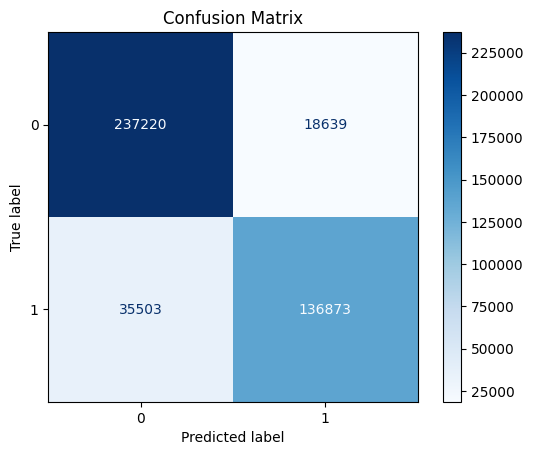

f1 binary: 0.0
f1 macro: 1.0
score: 0.5
13383/13383 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step


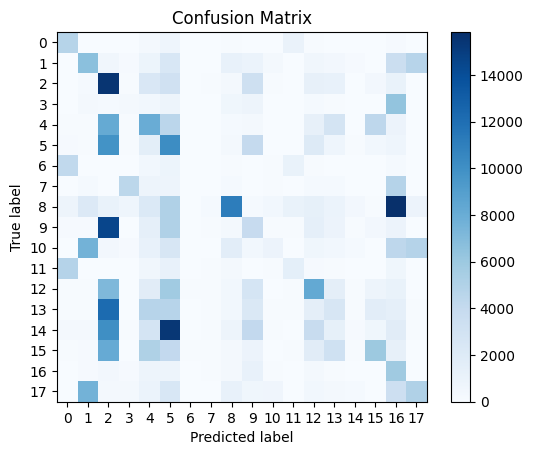

f1 binary: 0.5131211104232511
f1 macro: 0.1531983537065026
score: 0.33315973206487687


In [100]:
y_pred = np.argmax(model_s.predict(data_dic['X_train']), axis=1)

suffix = "_s"
# Example true and predicted labels
y_true = data_dic['y_train'+suffix] #[0, 1, 2, 2, 0]
#y_pred = [0, 0, 2, 2, 1]



# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot using sklearn's ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

score = score_model(y_pred, y_true)

y_pred = np.argmax(model_g.predict(data_dic['X_train']), axis=1)

suffix = "_g"
# Example true and predicted labels
y_true = data_dic['y_train'+suffix] #[0, 1, 2, 2, 0]
#y_pred = [0, 0, 2, 2, 1]



# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot using sklearn's ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, include_values=False)
plt.title("Confusion Matrix")
plt.show()

score = score_model(y_pred, y_true)

w/ stage 1 layers unfrozen

| Model | Train Accuracy | Eval Accuracy | Test Accuracy | runtime    |
|-------|----------------|---------------|---------------|------------|
| S2_g  |   0.5566       |   0.5780      |   0.5357      | 0:01:24.61 |
| S1_p  |   0.8696       |   0.8726      |   0.8604      | 0:01:31.93 |


w/ stage 1 layers frozen

| Model | Train Accuracy | Eval Accuracy | Test Accuracy | runtime    |
|-------|----------------|---------------|---------------|------------|
| S2_g  |   0.6044       |   0.5929      |   0.5467      | 0:01:15.42 |
| S1_p  |   0.8842       |   0.8839      |   0.875       | 0:01:09.89 |

## Model: CNN

### Stage 1 - DNN w/o tof

In [ ]:
# Compile & Fit Stage 1 models
hist = {}
t_acc = {}

for suffix in ["_o", "_b", "_p"]:

  models[suffix].trainable = True
  start = datetime.now()

  print(type(data_dic['X_train_non_tof']))
  print(type(data_dic['y_train'+suffix]))

  models[suffix].compile(loss=model_info['loss'], optimizer="adam",#model_info['optimizer'],
                         metrics=["accuracy"])
  hist[suffix] = models[suffix].fit(
      x = data_dic['X_train_non_tof'],
      y = data_dic['y_train'+suffix],
      epochs=model_info['epochs'],
      callbacks=[TimeCallback()],
      validation_split=0.2,
      )

  stop = datetime.now()
  #model_info['tdelta'] = str(stop-start)
  print("model"+suffix+" Runtime: ", str(stop-start))

  print("Evaluate model")
  t_acc["model"+suffix] = str(round(models[suffix].evaluate(data_dic['X_test_non_tof'], data_dic['y_train'+suffix], verbose=True)[1],4))
  print("Test accuracy: ",t_acc["model"+suffix])

### Stage 1 - CNN w/ tof

In [ ]:
# Stage 1
models = {}

model_o_cnn = keras.Sequential(
    [
        # Block 1
        keras.Input(shape=(8, 8, 5)),
        keras.layers.Conv2D(10, kernel_size=(1, 1), activation=model_info['activation']),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),

        # Block 2
        keras.layers.Conv2D(20, kernel_size=(1, 1), activation=model_info['activation']),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),

        keras.layers.Conv2D(10, kernel_size=(1, 1), activation=model_info['activation']),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),

        keras.layers.Flatten(),
        keras.layers.Dense(4, activation=model_info['final_activation']),
    ],
    name = 'CNN-cmi_o'
    )

model_b_cnn = keras.Sequential(
    [
        # Block 1
        keras.Input(shape=(8, 8, 5)),
        keras.layers.Conv2D(10, kernel_size=(1, 1), activation=model_info['activation']),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),

        # Block 2
        keras.layers.Conv2D(20, kernel_size=(1, 1), activation=model_info['activation']),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),

        keras.layers.Conv2D(10, kernel_size=(1, 1), activation=model_info['activation']),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),

        keras.layers.Flatten(),
        keras.layers.Dense(4, activation=model_info['final_activation']),
    ],
    name = 'CNN-cmi_b'
    )

model_p_cnn = keras.Sequential(
    [
        # Block 1
        keras.Input(shape=(8, 8, 5)),
        keras.layers.Conv2D(10, kernel_size=(1, 1), activation=model_info['activation']),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),

        # Block 2
        keras.layers.Conv2D(20, kernel_size=(1, 1), activation=model_info['activation']),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),

        keras.layers.Conv2D(10, kernel_size=(1, 1), activation=model_info['activation']),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),

        keras.layers.Flatten(),
        keras.layers.Dense(2, activation=model_info['final_activation']),
    ],
    name = 'CNN-cmi_p'
    )
models['_o_cnn'] = model_o_cnn
models['_b_cnn'] = model_b_cnn
models['_p_cnn'] = model_p_cnn

for suffix in ['_o_cnn', '_b_cnn', '_p_cnn']:
  print(models[suffix].summary())

Model: "CNN-cmi_o"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 8, 8, 10)       │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 4, 4, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 4, 4, 20)       │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 2, 2, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 2, 2, 10)       │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 4)              │            44 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 534 (2.09 KB)

 Trainable params: 534 (2.09 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "CNN-cmi_b"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 10)       │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 20)       │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 2, 2, 10)       │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 4)              │            44 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 534 (2.09 KB)

 Trainable params: 534 (2.09 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "CNN-cmi_p"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 10)       │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 4, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 20)       │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 2, 2, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 2, 2, 10)       │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 1, 1, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 512 (2.00 KB)

 Trainable params: 512 (2.00 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
hist = {}
t_acc = {}

for suffix in ["_o_cnn", "_b_cnn", "_p_cnn"]:
  data_suffix = "_"+suffix.split("_")[1]

  models[suffix].trainable = True
  start = datetime.now()

  print(type(data_dic['X_train_tof']))
  print(type(data_dic['y_train'+data_suffix]))

  models[suffix].compile(loss=model_info['loss'], optimizer="adam",#model_info['optimizer'],
                         metrics=["accuracy"])
  hist[suffix] = models[suffix].fit(
      x = data_dic['X_train_tof'],
      y = data_dic['y_train'+data_suffix],
      epochs=model_info['epochs'],
      callbacks=[TimeCallback()],
      validation_split=0.2,
      )

  stop = datetime.now()
  #model_info['tdelta'] = str(stop-start)
  print("model"+suffix+" Runtime: ", str(stop-start))

  print("Evaluate model")
  t_acc["model"+suffix] = str(round(models[suffix].evaluate(data_dic['X_test_tof'], data_dic['y_test'+data_suffix], verbose=True)[1],4))
  print("Test accuracy: ",t_acc["model"+suffix])


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
2025-07-10 20:24:50 ---Epoch 1/5
2629/2629 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.3940 - loss: 1.3196 - val_accuracy: 0.3847 - val_loss: 1.3205
2025-07-10 20:25:01 ---Epoch 2/5
2629/2629 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.4196 - loss: 1.2843 - val_accuracy: 0.3900 - val_loss: 1.3011
2025-07-10 20:25:11 ---Epoch 3/5
2629/2629 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.4279 - loss: 1.2714 - val_accuracy: 0.4023 - val_loss: 1.2891
2025-07-10 20:25:21 ---Epoch 4/5
2629/2629 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.4366 - loss: 1.2617 - val_accuracy: 0.4154 - val_loss: 1.2862
2025-07-10 20:25:31 ---Epoch 5/5
2629/2629 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.4405 - loss: 1.2545 - val_accuracy: 0.4215 - val_loss: 1.2672
model_o_cnn Runtime:  0:00:52.857149
Evaluate model
13475/13475 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - accuracy: 0.4133 - loss: 1.2889
Test accuracy:  0.4171
<class 'numpy.ndarray'>
<class '

| Model  | Train Accuracy | Eval Accuracy | Test Accuracy | runtime    |
|--------|----------------|---------------|---------------|------------|
| S1_o*  |   0.8907       |   0.3666      |   0.3595      | 0:00:13.32 |
| S1_b*  |   0.7232       |   0.2311      |   0.2476      | 0:00:13.87 |
| S1_p   |   0.8027       |   0.4016      |   0.4149      | 0:00:16.70 |
| S1_o_cnn  |   0.4338       |   0.4199      |   0.4226      | 0:01:11.89 |
| S1_b_cnn  |   0.5340       |   0.5429      |   0.5375      | 0:01:26.94 |
| S1_p_cnn  |   0.6580       |   0.6535      |   0.6507      | 0:01:44.77 |


### Stage 2

In [79]:
# Build, Compile, & Fit Stage 2 models
"""
Stage 1
- 3 CNN w/ tof sensors
- 3 DNN w/ 12 other sensors
Stage 2
- 2 DNN w/ 6 outputs + 12 sensors + x sub outputs from CNN
"""

for m in ["_o_cnn", "_b_cnn", "_p_cnn", "_o", "_b", "_p"]:
    models[m].trainable = False

inp = keras.Input(shape=(332,))

# Split input
x_3d = keras.layers.Lambda(lambda x: keras.backend.reshape(x[:, :12], (-1, 5, 8, 8)))(inp)
x_12 = keras.layers.Lambda(lambda x: x[:, -320:])(inp)


out_o      = models["_o"](inp)                    # <-- CALL; now outA is a tensor
out_b      = models["_b"](inp)
out_p      = models["_p"](inp)
out_o_cnn      = models["_o_cnn"](x_3d)                    # <-- CALL; now outA is a tensor
out_b_cnn      = models["_b_cnn"](x_3d)
out_p_cnn      = models["_p_cnn"](x_3d)

merged    = keras.layers.Concatenate()([out_o, out_b, out_p, inp])

x = keras.layers.Dense(256, activation="relu")(merged)
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.Dense(32, activation="relu")(x)

final_out_g = keras.layers.Dense(18, activation="softmax")(x)
final_out_s = keras.layers.Dense(2, activation="softmax")(x)

model_g = keras.Model(inputs = inp, outputs=final_out_g)
print(model_g.summary())

start = datetime.now()
model_g.compile(loss=model_info['loss'], optimizer="adam",#model_info['optimizer'],
                         metrics=["accuracy"])
hist_g = model_g.fit(
      x = data_dic['X_train_non_tof'],
      y = data_dic['y_train_g'],
      epochs=model_info['epochs'],
      callbacks=[TimeCallback()],
      validation_split=0.2,
      )

stop = datetime.now()
#model_info['tdelta'] = str(stop-start)
print("model_g Runtime: ", str(stop-start))

print("Evaluate model")
model_g_t_acc = str(round(model_g.evaluate(X_test, y_test, verbose=True)[1],4))
print("Test accuracy: ",model_g_t_acc)

model_s = keras.Model(inputs = inp, outputs=final_out_s)
print(model_s.summary())

start = datetime.now()
model_s.compile(loss=model_info['loss'], optimizer="adam",#model_info['optimizer'],
                         metrics=["accuracy"])
hist_s = model_s.fit(
      x = data_dic['X_train_non_tof'],
      y = data_dic['y_train_s'],
      epochs=model_info['epochs'],
      callbacks=[TimeCallback()],
      validation_split=0.2,
      )

stop = datetime.now()
#model_info['tdelta'] = str(stop-start)
print("model_s Runtime: ", str(stop-start))

print("Evaluate model")
model_s_t_acc = str(round(model_s.evaluate(X_test, y_test, verbose=True)[1],4))
print("Test accuracy: ",model_s_t_acc)

NameError: name 'models' is not defined

In [ ]:
suffix = "_s"
y_pred = np.argmax(comb_models['rnn'+suffix].predict(data_dic['X_test_rnn']), axis=1)


# Example true and predicted labels
y_true = data_dic['y_test'+suffix] #[0, 1, 2, 2, 0]
#y_pred = [0, 0, 2, 2, 1]



# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot using sklearn's ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

score = score_model(y_pred, y_true)

## Evaluation:
- F1 score

In [ ]:
from sklearn.metrics import f1_score

binary_arr = y_test["target"].gt(0.5).to_numpy()
y_pred_bin = (lr_model.predict(data_dic['X_test']) >= 0.5)

# Compute binary F1 (Target vs Non-Target)
# y_true_bin = sol['gesture'].isin(self.target_gestures).values
# y_pred_bin = sub['gesture'].isin(self.target_gestures).values
f1_binary = f1_score(
    binary_arr,
    y_pred_bin,
    pos_label=1,
    zero_division=0,
    average='binary'
)
print(f1_binary)

In [ ]:
"""
Hierarchical macro F1 metric for the CMI 2025 Challenge.

This script defines a single entry point `score(solution, submission, row_id_column_name)`
that the Kaggle metrics orchestrator will call.
It performs validation on submission IDs and computes a combined binary & multiclass F1 score.
"""

import pandas as pd
from sklearn.metrics import f1_score


class ParticipantVisibleError(Exception):
    """Errors raised here will be shown directly to the competitor."""
    pass


class CompetitionMetric:
    """Hierarchical macro F1 for the CMI 2025 challenge."""
    def __init__(self):
        self.target_gestures = [
            'Above ear - pull hair',
            'Cheek - pinch skin',
            'Eyebrow - pull hair',
            'Eyelash - pull hair',
            'Forehead - pull hairline',
            'Forehead - scratch',
            'Neck - pinch skin',
            'Neck - scratch',
        ]
        self.non_target_gestures = [
            'Write name on leg',
            'Wave hello',
            'Glasses on/off',
            'Text on phone',
            'Write name in air',
            'Feel around in tray and pull out an object',
            'Scratch knee/leg skin',
            'Pull air toward your face',
            'Drink from bottle/cup',
            'Pinch knee/leg skin'
        ]
        self.all_classes = self.target_gestures + self.non_target_gestures

    def calculate_hierarchical_f1(
        self,
        sol: pd.DataFrame,
        sub: pd.DataFrame
    ) -> float:

        # Validate gestures
        invalid_types = {i for i in sub['gesture'].unique() if i not in self.all_classes}
        if invalid_types:
            raise ParticipantVisibleError(
                f"Invalid gesture values in submission: {invalid_types}"
            )

        # Compute binary F1 (Target vs Non-Target)
        y_true_bin = sol['gesture'].isin(self.target_gestures).values
        y_pred_bin = sub['gesture'].isin(self.target_gestures).values
        f1_binary = f1_score(
            y_true_bin,
            y_pred_bin,
            pos_label=True,
            zero_division=0,
            average='binary'
        )

        # Build multi-class labels for gestures
        y_true_mc = sol['gesture'].apply(lambda x: x if x in self.target_gestures else 'non_target')
        y_pred_mc = sub['gesture'].apply(lambda x: x if x in self.target_gestures else 'non_target')

        # Compute macro F1 over all gesture classes
        f1_macro = f1_score(
            y_true_mc,
            y_pred_mc,
            average='macro',
            zero_division=0
        )

        return 0.5 * f1_binary + 0.5 * f1_macro


def score(
    solution: pd.DataFrame,
    submission: pd.DataFrame,
    row_id_column_name: str
    ) -> float:
    """
    Compute hierarchical macro F1 for the CMI 2025 challenge.

    Expected input:
      - solution and submission as pandas.DataFrame
      - Column 'sequence_id': unique identifier for each sequence
      - 'gesture': one of the eight target gestures or "Non-Target"

    This metric averages:
    1. Binary F1 on SequenceType (Target vs Non-Target)
    2. Macro F1 on gesture (mapping non-targets to "Non-Target")

    Raises ParticipantVisibleError for invalid submissions,
    including invalid SequenceType or gesture values.


    Examples
    --------
    >>> import pandas as pd
    >>> row_id_column_name = "id"
    >>> solution = pd.DataFrame({'id': range(4), 'gesture': ['Eyebrow - pull hair']*4})
    >>> submission = pd.DataFrame({'id': range(4), 'gesture': ['Forehead - pull hairline']*4})
    >>> score(solution, submission, row_id_column_name=row_id_column_name)
    0.5
    >>> submission = pd.DataFrame({'id': range(4), 'gesture': ['Text on phone']*4})
    >>> score(solution, submission, row_id_column_name=row_id_column_name)
    0.0
    >>> score(solution, solution, row_id_column_name=row_id_column_name)
       1.0
    """
    # Validate required columns
    for col in (row_id_column_name, 'gesture'):
        if col not in solution.columns:
            raise ParticipantVisibleError(f"Solution file missing required column: '{col}'")
        if col not in submission.columns:
            raise ParticipantVisibleError(f"Submission file missing required column: '{col}'")

    metric = CompetitionMetric()
    return metric.calculate_hierarchical_f1(solution, submission)

# Time Series

Can we just run the data through a RNN

- Need to preprocess for batch data


## Preprocess data

In [ ]:
grouped_dict_y = {'sid':[], 'target_s':[], 'target_g':[]}

for sid in grouped_dict.keys():
  grouped_dict_y['sid'].append(sid)
  grouped_dict_y['target_s'].append(grouped_dict[sid]['target_s'][0])
  grouped_dict_y['target_g'].append(grouped_dict[sid]['target_g'][0])

  if len(np.unique(grouped_dict[sid]['target_s'])) > 1:
    print(sid+' target_s is not unique')
  if len(np.unique(grouped_dict[sid]['target_s'])) > 1:
    print(sid+' target_s is not unique')
y_data = pl.DataFrame(grouped_dict_y)

data_dic['y_train_s'] = np.asarray((y_data.filter(pl.col("sid").is_in(train_ids)).select('target_s')))
data_dic['y_train_g'] = np.asarray((y_data.filter(pl.col("sid").is_in(train_ids)).select('target_g')))

data_dic['y_test_s'] = np.asarray((y_data.filter(pl.col("sid").is_in(test_ids)).select('target_s')))
data_dic['y_test_g'] = np.asarray((y_data.filter(pl.col("sid").is_in(test_ids)).select('target_g')))

In [ ]:
# Prep X data

def pad_seq(seq, max_len):
  t = seq.shape[0]
  if t < max_len:
    pad_width = ((0, max_len - t), (0, 0))  # pad along time axis only
    return np.pad(seq, pad_width, mode='constant')
  else:
      return seq[:MAX_LEN]  # truncate if longer

data_dic['X_train'] = []
data_dic['X_test'] = []

cnt = 0
for sid in train_ids:
  if sid in grouped_dict.keys():
    seq = grouped_dict[sid].select(train_features_norm).to_numpy()
    data_dic['X_train'].append(pad_seq(seq, 100))

print('')
for sid in test_ids:
  cnt += 1
  if cnt > 49:
    print(".",end="")
    cnt = 0

  if sid in grouped_dict.keys():
    seq = grouped_dict[sid].select(train_features_norm).to_numpy()
    data_dic['X_test'].append(pad_seq(seq, 100))

data_dic['X_train'] = np.array(data_dic['X_train'])
data_dic['X_test'] = np.array(data_dic['X_test'])


................................

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (6079,) + inhomogeneous part.

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (1516,) + inhomogeneous part.

In [ ]:
for seq in data_dic['X_train']:
  print(len(seq))

200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200


In [ ]:
for key, value in data_dic.items():
  print(key)
  print(type(value))
  print(len(value))

y_train_s
<class 'numpy.ndarray'>
6079
y_train_g
<class 'numpy.ndarray'>
6079
X_train
<class 'numpy.ndarray'>
6079
X_test
<class 'list'>
1516
y_test_s
<class 'numpy.ndarray'>
1516
y_test_g
<class 'numpy.ndarray'>
1516


## RNN

In [76]:
#model_s = keras.Sequential([
#    keras.layers.Input(shape=(100, 332)),
#    keras.layers.LSTM(128),
#    keras.layers.LSTM(64),
#    keras.layers.Dense(2, activation='softmax')  # Or softmax, depending on task
#])

model_g = keras.Sequential([
    keras.layers.Input(shape=(100, 332)),
    #keras.layers.LSTM(256, return_sequences=True),
    keras.layers.LSTM(128, dropout=0.3, return_sequences=True),
    keras.layers.LSTM(64, dropout=0.3), #, return_sequences=True),
    #keras.layers.LSTM(32),
    keras.layers.Dense(18, activation='softmax')  # Or softmax, depending on task
])
#final_out_g = keras.layers.Dense(18, activation="softmax")(x)

#model_s.summary()
model_g.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 100, 128)       │       236,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 18)             │         1,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,610 (1.09 MB)

 Trainable params: 286,610 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

In [82]:
from sklearn.utils import class_weight
y = np.array(data_dic['y_train_rnn_g']).ravel()

# Double-check the shape and dtype
print(y.shape, y.dtype)  # should be (N,) and int or compatible

# Compute class weights
cw = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights = dict(enumerate(cw))


(6091,) int64


In [98]:
start = datetime.now()

model_g.compile(loss=model_info['loss'], optimizer="adam",#model_info['optimizer'],
                        metrics=["accuracy"])
hist_g = model_g.fit(
    x = data_dic['X_train_rnn'],
    y = data_dic['y_train_g'],
    class_weight = class_weights,
    epochs=model_info['epochs'],
    callbacks=[TimeCallback()],
    validation_split=0.2,
    )

stop = datetime.now()
#model_info['tdelta'] = str(stop-start)
print("model_g Runtime: ", str(stop-start))

print("Evaluate model")
t_acc_g = str(round(model_g.evaluate(data_dic['X_train_rnn'], data_dic['y_train_rnn_g'], verbose=True)[1],4))
print("Test accuracy: ",t_acc_g)

2025-07-25 18:56:43 ---Epoch 1/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 24s 142ms/step - accuracy: 0.0489 - loss: 2.9173 - val_accuracy: 0.0000e+00 - val_loss: 2.9747
2025-07-25 18:57:07 ---Epoch 2/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 22s 141ms/step - accuracy: 0.0537 - loss: 2.8594 - val_accuracy: 0.0000e+00 - val_loss: 2.9838
2025-07-25 18:57:29 ---Epoch 3/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 0.0484 - loss: 2.9181 - val_accuracy: 0.0000e+00 - val_loss: 3.0070
2025-07-25 18:57:50 ---Epoch 4/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - accuracy: 0.0497 - loss: 2.8801 - val_accuracy: 0.0000e+00 - val_loss: 2.9706
2025-07-25 18:58:10 ---Epoch 5/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 0.0512 - loss: 2.8947 - val_accuracy: 0.0000e+00 - val_loss: 2.9937
model_g Runtime:  0:01:49.368963
Evaluate model
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.0211 - loss: 3.2249
Test accuracy:  0.0212


47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step


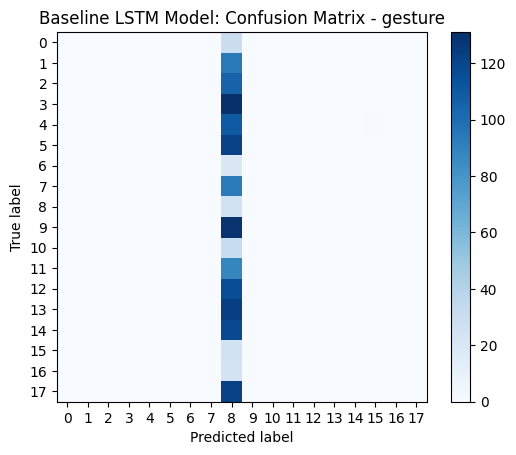

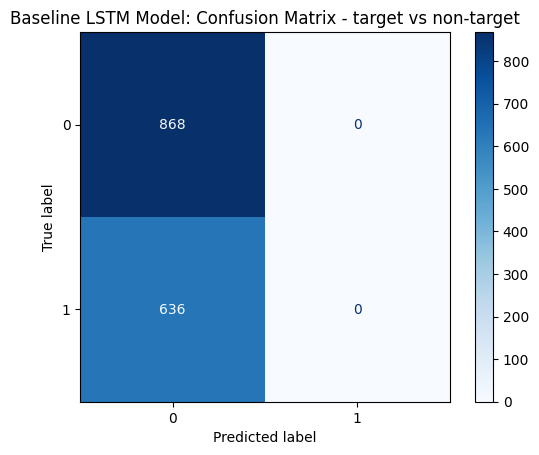

f1 binary: 0.0
f1 macro: 0.09090909090909091
score: 0.045454545454545456


In [112]:
y_pred = np.argmax(model_g.predict(data_dic['X_test_rnn']), axis=1)

# Example true and predicted labels
y_true = data_dic['y_test_rnn'+suffix] #[0, 1, 2, 2, 0]
#y_pred = [0, 0, 2, 2, 1]

score = score_model(y_pred, y_true, title="Baseline LSTM Model")

In [108]:
320/332

0.963855421686747

/tmp/ipython-input-107-2060582079.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


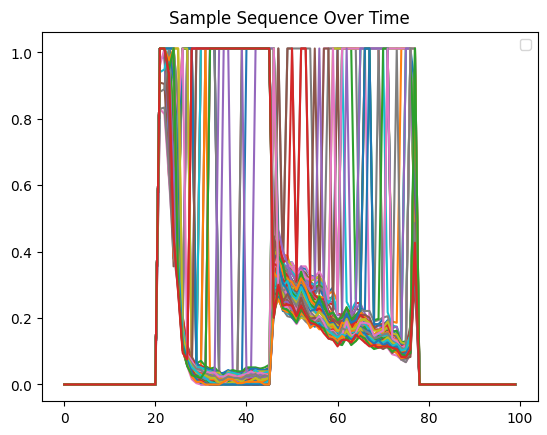

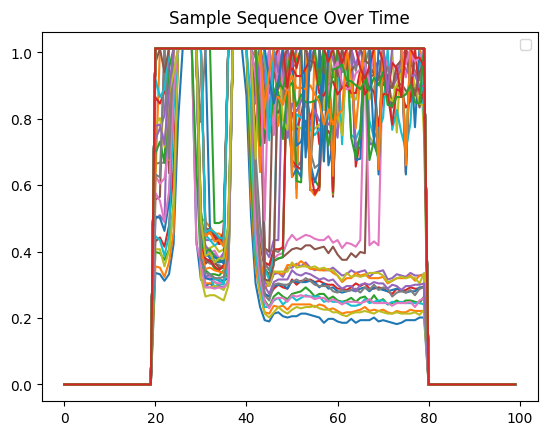

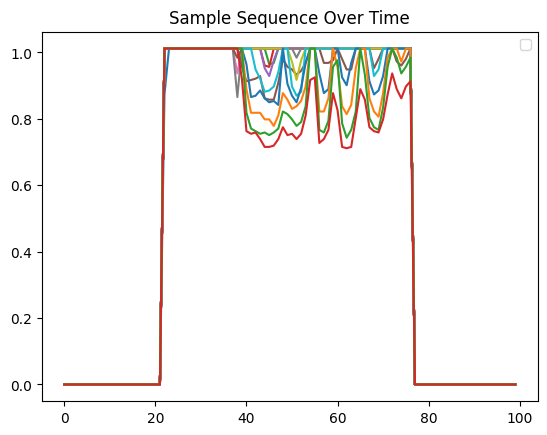

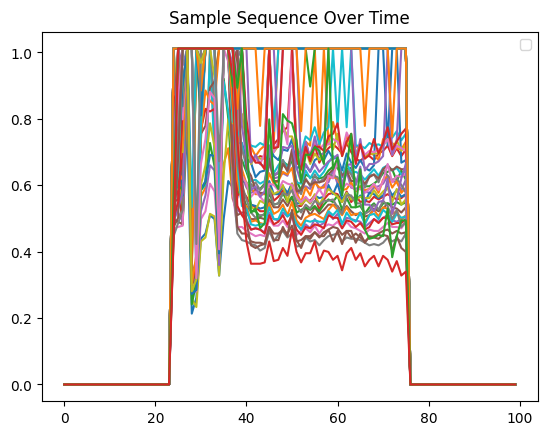

In [107]:

for n in [0,200,30,67]:
  sample = data_dic['X_train_rnn'][n]  # shape: (timesteps, features)

  for i in range(min(64, sample.shape[1])):  # plot first 5 features
      i = i+12
      plt.plot(sample[:, i])#, label=f'Feature {i}')
  plt.title("Sample Sequence Over Time")
  plt.legend()
  plt.show()

In [ ]:


start = datetime.now()

model_s.compile(loss=model_info['loss'], optimizer="adam",#model_info['optimizer'],
                        metrics=["accuracy"])
hist_s = model_s.fit(
    x = data_dic['X_train'],
    y = data_dic['y_train_s'],
    epochs=model_info['epochs'],
    callbacks=[TimeCallback()],
    validation_split=0.2,
    )

stop = datetime.now()
#model_info['tdelta'] = str(stop-start)
print("model_s Runtime: ", str(stop-start))

print("Evaluate model")
t_acc_s = str(round(model_s.evaluate(data_dic['X_train'], data_dic['y_train_s'], verbose=True)[1],4))
print("Test accuracy: ",t_acc_s)

In [ ]:
start = datetime.now()

model_s.compile(loss=model_info['loss'], optimizer="adam",#model_info['optimizer'],
                        metrics=["accuracy"])
hist_s = model_s.fit(
    x = data_dic['X_train'],
    y = data_dic['y_train_s'],
    epochs=model_info['epochs'],
    callbacks=[TimeCallback()],
    validation_split=0.2,
    )

stop = datetime.now()
#model_info['tdelta'] = str(stop-start)
print("model_s Runtime: ", str(stop-start))

print("Evaluate model")
t_acc_s = str(round(model_s.evaluate(data_dic['X_train'], data_dic['y_train_s'], verbose=True)[1],4))
print("Test accuracy: ",t_acc_s)

In [ ]:
start = datetime.now()

model_s.compile(loss=model_info['loss'], optimizer="adam",#model_info['optimizer'],
                        metrics=["accuracy"])
hist_s = model_s.fit(
    x = data_dic['X_train'],
    y = data_dic['y_train_s'],
    epochs=model_info['epochs'],
    callbacks=[TimeCallback()],
    validation_split=0.2,
    )

stop = datetime.now()
#model_info['tdelta'] = str(stop-start)
print("model_s Runtime: ", str(stop-start))

print("Evaluate model")
t_acc_s = str(round(model_s.evaluate(data_dic['X_train'], data_dic['y_train_s'], verbose=True)[1],4))
print("Test accuracy: ",t_acc_s)

# Combined models

- Stage 1
  - CNN (5x8x8) -> (5x5)
- Stage 2
  - DNN (12) -> (1)
  - DNN (12) -> (1)
  - DNN (12) -> (1)
- Stage 3
  - RNN (200 x 40) -> (1)
  - RNN (200 x 40) -> (1)
  

In [ ]:
comb_models = {}

## CNN model


This model will need to be trained with the whole model because we dont know what to expect for the 25 outputs.

In [ ]:
kernel_size = 3
input_size = 2

output_size = input_size - kernel_size + 1
print(output_size)


0


In [ ]:
# Build
model_cnn = keras.Sequential(
    [
        keras.Input(shape=(8, 8, 5)),
        keras.layers.Conv2D(8, kernel_size=(3, 3), activation=model_info['activation']),
        keras.layers.Conv2D(16, kernel_size=(3, 3), activation=model_info['activation']),
        keras.layers.Conv2D(8, kernel_size=(3, 3), activation=model_info['activation']),
        keras.layers.Flatten(),
        keras.layers.Dense(25, activation=model_info['final_activation']),
    ],
    name = 'cmi-CNN'
    )
comb_models['cnn'] = model_cnn

model_cnn.summary()

Model: "cmi-CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 6, 6, 8)        │           368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 4, 4, 16)       │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 2, 2, 8)        │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 25)             │           825 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,521 (13.75 KB)

 Trainable params: 3,521 (13.75 KB)

 Non-trainable params: 0 (0.00 B)

## DNN models

These also need to be trained with the big model because they take in the 25 parameters from the CNN

In [ ]:
# Models with 12 + 25 inputs

model_info = {
        'epochs': 5,
        'learning_rate': 0.01,
        'loss':  keras.losses.SparseCategoricalCrossentropy(), # multiclass crossentropy
        "activation": 'relu',
        "final_activation": 'softmax',
}

model_info["optimizer"] = keras.optimizers.Adam(learning_rate=model_info['learning_rate'])

model_o = keras.Sequential(
            [
                keras.Input(shape=(37,)),
                keras.layers.Dense(32, activation=model_info['activation']),
                keras.layers.Dense(16, activation=model_info['activation']),
                keras.layers.Dense(8, activation=model_info['activation']),
                keras.layers.Dense(4, activation=model_info['final_activation']),
            ],
            name = 'cmi-orientation-DNN'
            )

model_b = keras.Sequential(
            [
                keras.Input(shape=(37,)),
                keras.layers.Dense(32, activation=model_info['activation']),
                keras.layers.Dense(16, activation=model_info['activation']),
                keras.layers.Dense(8, activation=model_info['activation']),
                keras.layers.Dense(4, activation=model_info['final_activation']),
            ],
            name = 'cmi-behavior-DNN'
            )

model_p = keras.Sequential(
            [
                keras.Input(shape=(37,)),
                keras.layers.Dense(32, activation=model_info['activation']),
                keras.layers.Dense(16, activation=model_info['activation']),
                keras.layers.Dense(8, activation=model_info['activation']),
                keras.layers.Dense(4, activation=model_info['activation']),
                keras.layers.Dense(2, activation=model_info['final_activation']),
            ],
            name = 'cmi-phase-DNN'
            )


comb_models['_o'] = model_o
comb_models['_b'] = model_b
comb_models['_p'] = model_p





## RNN

In [ ]:
model_s = keras.Sequential([
    keras.layers.Input(shape=(200, 40)),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(64),
    keras.layers.Dense(2, activation='softmax')
],name = 'cmi-sequence_type-LSTM')

model_g = keras.Sequential([
    keras.layers.Input(shape=(200, 40)),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(64),
    keras.layers.Dense(18, activation='softmax')
],name = 'cmi-gesture-LSTM')

comb_models['_g'] = model_g
comb_models['_s'] = model_s

In [ ]:
for models in comb_models.values():
  print(models.summary())

Model: "cmi-orientation-DNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,916 (7.48 KB)

 Trainable params: 1,916 (7.48 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "cmi-behavior-DNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 32)             │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,916 (7.48 KB)

 Trainable params: 1,916 (7.48 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "cmi-phase-DNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 32)             │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 2)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,926 (7.52 KB)

 Trainable params: 1,926 (7.52 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "cmi-CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 6, 6, 8)        │           368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 4, 4, 16)       │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 2, 2, 8)        │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 25)             │           825 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,521 (13.75 KB)

 Trainable params: 3,521 (13.75 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "cmi-gesture-LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 200, 64)        │        26,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 200, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 18)             │         1,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 176,274 (688.57 KB)

 Trainable params: 176,274 (688.57 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "cmi-sequence_type-LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 200, 64)        │        26,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 200, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 175,234 (684.51 KB)

 Trainable params: 175,234 (684.51 KB)

 Non-trainable params: 0 (0.00 B)

None


## Stage 1

In [ ]:
# Stage 1 Models: CNN -> DNN ->

In [ ]:
input_vector = keras.Input(shape=(332,)) # Input vector is going to include sequence_id so that we can split along sequence id for the RNN.

#seq_id = keras.layers.Lambda(lambda x: x[:, 1])(input_vector)

# CNN model
cnn_input = keras.layers.Lambda(lambda x: x[:, 12:])(input_vector)
reshaped_cnn_input = keras.layers.Reshape((8, 8, 5))(cnn_input)

cnn_output = comb_models['cnn'](reshaped_cnn_input)

# DNN model
dnn_remain_input = keras.layers.Lambda(lambda x: x[:, :12])(input_vector)
dnn_input = keras.layers.Concatenate()([cnn_output, dnn_remain_input])

dnn_o_output = comb_models['_o'](dnn_input)
dnn_b_output = comb_models['_b'](dnn_input)
dnn_p_output = comb_models['_p'](dnn_input)

# RNN model
#rnn_input = keras.layers.Concatenate()([seq_id, cnn_output, dnn_remain_input, dnn_o_output, dnn_b_output, dnn_p_output])
# groupby & remove seq_id

# pad to 200



In [ ]:
cnn_dnn_o_model = keras.Model(inputs=input_vector, outputs=dnn_o_output)
cnn_dnn_b_model = keras.Model(inputs=input_vector, outputs=dnn_b_output)
cnn_dnn_p_model = keras.Model(inputs=input_vector, outputs=dnn_p_output)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 332)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 320)       │          0 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 8, 8, 5)   │          0 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cmi-CNN             │ (None, 25)        │      3,521 │ reshape[0][0]     │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 12)        │          0 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 37)        │          0 │ cmi-CNN[0][0],    │
│ (Concatenate)       │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cmi-orientation-DNN │ (None, 4)         │      1,916 │ concatenate[0][0] │
│ (Sequential)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,437 (21.24 KB)

 Trainable params: 5,437 (21.24 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
stop = datetime.now()

start = datetime.now()
cnn_dnn_o_model.compile(loss=model_info['loss'], optimizer="adam",#model_info['optimizer'],
                         metrics=["accuracy"])
hist = cnn_dnn_o_model.fit(
      x = data_dic['X_train'],
      y = data_dic['y_train_o'],
      epochs=model_info['epochs'],
      callbacks=[TimeCallback()],
      validation_split=0.2,
      )

stop = datetime.now()
#model_info['tdelta'] = str(stop-start)
print("model_s Runtime: ", str(stop-start))

print("Evaluate model")
model_s_t_acc = str(round(cnn_dnn_o_model.evaluate(data_dic['X_test'], data_dic['y_test_o'], verbose=True)[1],4))
print("Test accuracy: ",model_s_t_acc)

stop = datetime.now()

start = datetime.now()
cnn_dnn_b_model.compile(loss=model_info['loss'], optimizer="adam",#model_info['optimizer'],
                         metrics=["accuracy"])
hist = cnn_dnn_b_model.fit(
      x = data_dic['X_train'],
      y = data_dic['y_train_b'],
      epochs=model_info['epochs'],
      callbacks=[TimeCallback()],
      validation_split=0.2,
      )

stop = datetime.now()
#model_info['tdelta'] = str(stop-start)
print("model_s Runtime: ", str(stop-start))

print("Evaluate model")
model_s_t_acc = str(round(cnn_dnn_b_model.evaluate(data_dic['X_test'], data_dic['y_test_b'], verbose=True)[1],4))
print("Test accuracy: ",model_s_t_acc)


stop = datetime.now()

start = datetime.now()
cnn_dnn_p_model.compile(loss=model_info['loss'], optimizer="adam",#model_info['optimizer'],
                         metrics=["accuracy"])
hist = cnn_dnn_p_model.fit(
      x = data_dic['X_train'],
      y = data_dic['y_train_p'],
      epochs=model_info['epochs'],
      callbacks=[TimeCallback()],
      validation_split=0.2,
      )

stop = datetime.now()
#model_info['tdelta'] = str(stop-start)
print("model_s Runtime: ", str(stop-start))

print("Evaluate model")
model_s_t_acc = str(round(cnn_dnn_p_model.evaluate(data_dic['X_test'], data_dic['y_test_p'], verbose=True)[1],4))
print("Test accuracy: ",model_s_t_acc)

2025-07-17 14:14:49 ---Epoch 1/5
10730/10730 ━━━━━━━━━━━━━━━━━━━━ 48s 4ms/step - accuracy: 0.9527 - loss: 0.1488 - val_accuracy: 0.9278 - val_loss: 0.2278
2025-07-17 14:15:38 ---Epoch 2/5
10730/10730 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - accuracy: 0.9542 - loss: 0.1450 - val_accuracy: 0.9337 - val_loss: 0.2077
2025-07-17 14:16:24 ---Epoch 3/5
10730/10730 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step - accuracy: 0.9548 - loss: 0.1423 - val_accuracy: 0.9284 - val_loss: 0.2271
2025-07-17 14:17:10 ---Epoch 4/5
10730/10730 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - accuracy: 0.9552 - loss: 0.1418 - val_accuracy: 0.9308 - val_loss: 0.2192
2025-07-17 14:17:56 ---Epoch 5/5
10730/10730 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - accuracy: 0.9568 - loss: 0.1354 - val_accuracy: 0.9272 - val_loss: 0.2256
model_s Runtime:  0:03:54.985681
Evaluate model
3348/3348 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9320 - loss: 0.2423
Test accuracy:  0.929
2025-07-17 14:18:51 ---Epoch 1/5
10730/10730 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step

| Model  | Train Accuracy | Eval Accuracy | Test Accuracy | runtime    |
|--------|----------------|---------------|---------------|------------|
| S1_o   |   0.9568       |   0.9272      |   0.9290      |            |
| S1_b   |   0.6822       |   0.6438      |   0.6474      |            |
| S1_p   |   0.7820       |   0.7468      |   0.7489      |            |

## Stage 2

In [ ]:
model_s = keras.Sequential([
    keras.layers.Input(shape=(200, 40)),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(64),
    keras.layers.Dense(2, activation='softmax')
],name = 'cmi-sequence_type-LSTM')

In [ ]:
input_vector = keras.Input(shape=(333,)) # Input vector is going to include sequence_id so that we can split along sequence id for the RNN.

seq_id = keras.layers.Lambda(lambda x: x[:, 1])(input_vector)

# CNN model
cnn_input = keras.layers.Lambda(lambda x: x[:, 13:])(input_vector)
reshaped_cnn_input = keras.layers.Reshape((8, 8, 5))(cnn_input)

cnn_output = comb_models['cnn'](reshaped_cnn_input)

# DNN model
dnn_remain_input = keras.layers.Lambda(lambda x: x[:, 1:13])(input_vector)
dnn_input = keras.layers.Concatenate()([cnn_output, dnn_remain_input])

dnn_o_output = comb_models['_o'](dnn_input)
dnn_b_output = comb_models['_b'](dnn_input)
dnn_p_output = comb_models['_p'](dnn_input)

# RNN model
rnn_input = keras.layers.Concatenate()([cnn_output, dnn_remain_input, dnn_o_output, dnn_b_output, dnn_p_output],axis = 1)

df_stage2 = pd.DataFrame(rnn_input)
df_stage2['seq_id'] = seq_id

grouped_dict = {
    sid[0]: group
    for sid, group in df_stage2.group_by("seq_id", maintain_order=True)
}

rnn_input = []
for sid in train_ids:
  if sid in grouped_dict.keys():
    seq = grouped_dict[sid].select(train_features_norm).to_numpy()
    rnn_input.append(pad_seq(seq, 200))

rnn_input = np.array(rnn_input)



In [ ]:
# Predict outputs (N, 1) and features (N, 25)
#dnn_out, cnn_feats = dnn_feature_model.predict([cnn_data, dnn_data], batch_size=32)
full_feature_vecs = np.concatenate([cnn_output, dnn_remain_input, dnn_o_output, dnn_b_output, dnn_p_output], axis=1)  # shape (N, 38)

# Add seq_id column (assumed to be available)
df_stage2 = pd.DataFrame(full_feature_vecs)
df_stage2['seq_id'] = seq_ids

# Group by seq_id and pad to length 200
sequences = []
for _, group in df_stage2.groupby('seq_id'):
    seq = group.drop(columns='seq_id').values.astype(np.float32)
    sequences.append(seq)

padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(
    sequences, maxlen=200, padding='post', truncating='post', dtype='float32'
)

# y2: sequence-level labels (e.g., one per seq_id)
